#### Required Packages
1. poweRlaw
2. ipoptr

Let's first start by making all functions availble for simmulating, modeling and predicting cascades

In [1]:
## Just source the rscript provided
source('rscripts/marked_hawkes.R')

Loading required package: poweRlaw
Loading required package: ipoptr


## Simulation

We will start with visualizing how would kernel function for an event with mark 1000 evolve, where it's parameters are $\kappa = 0.8$, $\beta = 0.6$, $c = 10$ and $\theta = 0.8$. For any code where we want to use power law kernel we don't need to pass the kernel value as it's te defualt type implemented.

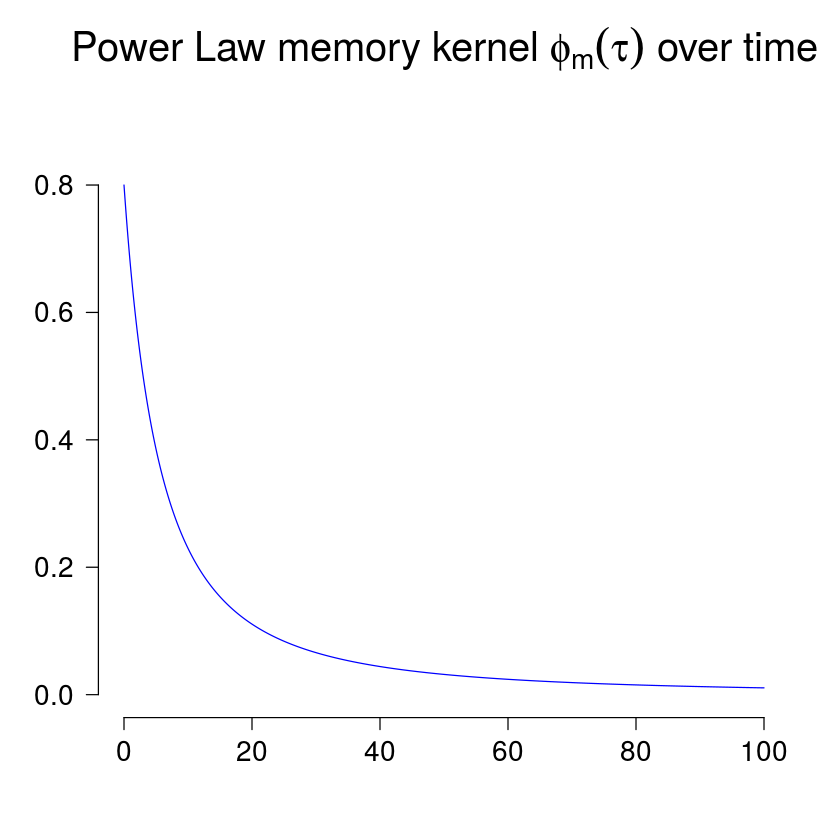

In [2]:
# initial event we want to use for simmulation
event <- c(1000, 0)
# series of time points we want to simmulate event for
t <- seq(from = 0, to = 100, length=1000)
# parameters for kernel
K <- 0.8
beta <- 0.6
c <- 10
theta <- 0.8

# Power Law Kernel
# calling the kernelfunction to get the values
values.PL <- kernelFct(event = event, t = t, K = K, beta = beta, c = c, theta = theta, kernel.type='PL')
# ploting the kernel function
plot(x = t, y = values.PL, type = 'l', col = 'blue', pch=16, bty = "n",
      lty = 1, las = 1, yaxt = "n", xaxt = "n", ylim = c(0, max(values.PL)+0.1),
        cex.main = 2, cex.lab = 1.8, cex.axis = 1.4,
        main = expression(paste("Power Law memory kernel ", phi[m] (tau), " over time")), ylab = "", xlab = "" )
axis(side = 2, las = 1, cex.axis = 1.4)
axis(side = 1, cex.axis = 1.4 )

We can also simulate a series of events generated by a hawkes process described by the parameters above. We have option to save it to a file and specify the time till we want events to b simulated. We can even simulate a series of events after providing an initial history.

In [3]:
# generating events till a time
events1 <- generate_Hawkes_event_series(K = K, beta = beta, c = c, theta = theta, Tmax = 50)
events2 <- generate_Hawkes_event_series(K = K, beta = beta, c = c, theta = theta, history_init = events1, Tmax = 60)

Current simulation time: 51.023 / 50.000 (46 events).
--> Simulation done!
Current simulation time: 61.158 / 60.000 (52 events).
--> Simulation done!


Now if we compare events2 and events1 we find events2 has all of events1 as prefix, with some extra generated events.

## Real Example

In this section, we first read a real twitter cascade and then fit a hawkes model to it after observing first 1 hours of cacscade and then we will do the final prediction. A retweet cascade is provided in the file 'example.csv' with each row representing an event with values of the form  

** [magnitude(#user followers), time(secs)] **

In [4]:
## read the real cascade provided in the file example.csv
real_cascade <- read.csv(file = 'example.csv', header = T)

In [5]:
## just looking at data
real_cascade[1:10, ]

X,magnitude,time
1,227381,0
2,439,10
3,93,11
4,92,12
5,553,13
6,1277,14
7,536,16
8,217,18
9,514,23
10,326,24


In [6]:
## reading the events uptill prediction time, 3600 secs, to be used for fitting
predTime <- 3600
history <- real_cascade[real_cascade$time <= predTime, ]

## Using Power Law Kernel as Social Kernel

In [7]:
## just to supress warnings as optimization 
oldw <- getOption("warn")
options(warn = -1)
## now for fitting we just call the fitting function, which uses IPOPT which needs some starting values for parameters
startParams <- c(K= 0.3,beta=0.3, c=3, theta= 0.2)
result <- fitParameters(startParams, history)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



In IPOPT the optimal values returned are in order they are passed to the objective function hence:

$\kappa = result\$solution[1]$

$\beta = result\$solution[2] $

$ c = result\$solution[3] $

$\theta = result\$solution[4] $

In [8]:
sprintf("Value of K =  %f", result$solution[1])
sprintf("Value of beta = %f", result$solution[2])
sprintf("Value of c =  %f", result$solution[3])
sprintf("Value of theta =  %f", result$solution[4])

[1] "Value of K =  0.039486"

[1] "Value of beta = 0.570309"

[1] "Value of c =  28.218724"

[1] "Value of theta =  0.301817"

Now we plot part of the observed event series and the corresponding intensity function with fitted parameters. We do not plot the whole observed parts as it's too big to be seen with useful information on a single small graph


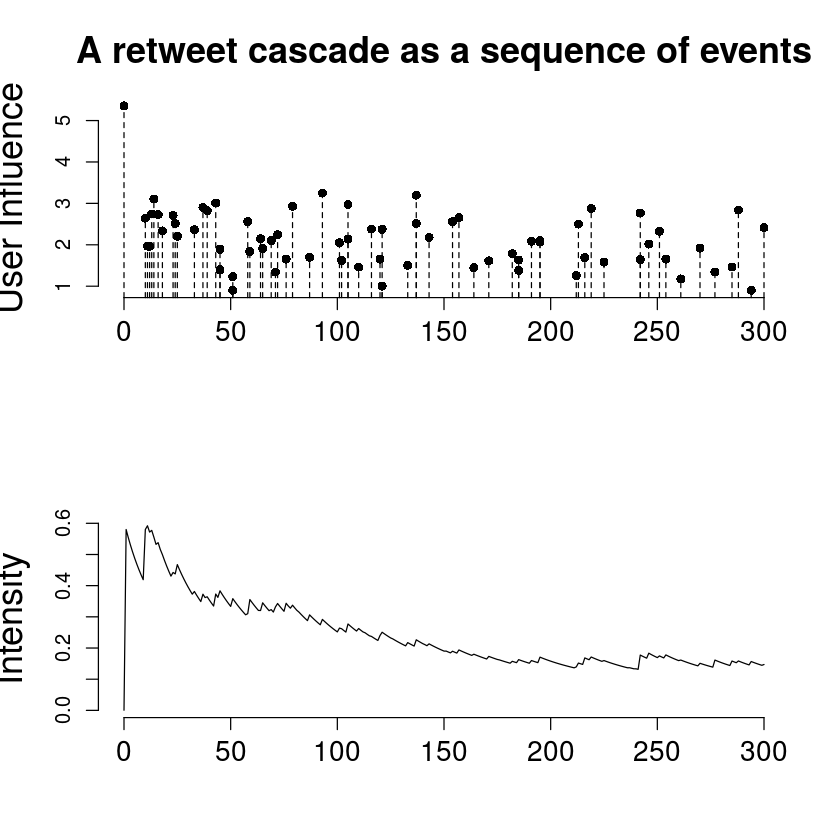

In [9]:
## length of time to use for plottig
plotTime <- 300

pltData <- history[history$time <= plotTime,]
intensity <- lambda(t=seq(0,plotTime,1), history = history, params = result$solution, inclusive = T)
par(mfrow=c(2,1))
data <- data.frame(time= seq(0,plotTime,1), intensity=intensity)

plot(x = pltData$time, y = log(pltData$magnitude, base = 10), type = 'p', col = 'black', pch=16, bty = "n",
         xaxt = "n", yaxt = "n", xlab = "", ylab = "User Influence", main = "A retweet cascade as a sequence of events",
         cex.main = 1.8, cex.lab = 1.8)
axis(side = 1, cex.axis=1.4)
segments(x0 =pltData$time, y0 = 0, x1 = pltData$time, y1 = log(pltData$magnitude, base = 10),lty = 2)
points(x = pltData$time, y = log(pltData$magnitude, base = 10), type = 'p', col = 'black', pch=16)
axis(side = 2)


plot(x = data$time, y = data$intensity, type = 'l', col = 'black', pch=16, bty = "n", 
     xaxt = "n", yaxt = "n", xlab = "", ylab = "Intensity",
     cex.main = 1.8, cex.lab = 1.8)
axis(side = 1, cex.axis=1.4)
axis(side = 2)



In [10]:
## To get predictions from fitted model we call the function provided in rscipts
prediction <- getTotalEvents(history = history, bigT = predTime, 
                             K = result$solution[1], alpha = 2.016, 
                             beta = result$solution[2], mmin = 1,                
                             c = result$solution[3], theta = result$solution[4])
# settings warnings back to deafult
options(warn = oldw)

In [11]:
prediction

total       nstar          a1 
233.0000000   0.1088324  56.2245069

In [12]:
## Total length of real casacde
nReal = nrow(real_cascade)
nPredicted = prediction['total']
sprintf("The real size of cascade is %d and predicted values is %d", nReal, nPredicted)
sprintf("The relative error in percentage is %0.2f", 100*abs(nReal-nPredicted)/nReal)

[1] "The real size of cascade is 247 and predicted values is 233"

[1] "The relative error in percentage is 5.67"

## Using Exponential Kernel as Social Kernel

In [ ]:
## just to supress warnings as optimization 
oldw <- getOption("warn")
options(warn = -1)
## now for fitting we just call the fitting function, which uses IPOPT which needs some starting values for parameters
startParams <- c(K= 0.3,beta=0.3, c=3, theta= 0.2)
result <- fitParameters(startParams, history, kernel.type = 'EXP')

In IPOPT the optimal values returned are in order they are passed to the objective function hence:

$\kappa = result\$solution[1]$

$\beta = result\$solution[2] $

$ c = result\$solution[3] $

$\theta = result\$solution[4] $

In [ ]:
sprintf("Value of K =  %f", result$solution[1])
sprintf("Value of beta = %f", result$solution[2])
## no significance of c, we have to use it just to have same call for all kernel types
sprintf("Value of c =  %f", result$solution[3])
sprintf("Value of theta =  %f", result$solution[4])

Now we plot part of the observed event series and the corresponding intensity function with fitted parameters. We do not plot the whole observed parts as it's too big to be seen with useful information on a single small graph


In [ ]:
## length of time to use for plottig
plotTime <- 300

pltData <- history[history$time <= plotTime,]
intensity <- lambda(t=seq(0,plotTime,1), history = history, params = result$solution, inclusive = T,  kernel.type = 'EXP')
par(mfrow=c(2,1))
data <- data.frame(time= seq(0,plotTime,1), intensity=intensity)

plot(x = pltData$time, y = log(pltData$magnitude, base = 10), type = 'p', col = 'black', pch=16, bty = "n",
         xaxt = "n", yaxt = "n", xlab = "", ylab = "User Influence", main = "A retweet cascade as a sequence of events",
         cex.main = 1.8, cex.lab = 1.8)
axis(side = 1, cex.axis=1.4)
segments(x0 =pltData$time, y0 = 0, x1 = pltData$time, y1 = log(pltData$magnitude, base = 10),lty = 2)
points(x = pltData$time, y = log(pltData$magnitude, base = 10), type = 'p', col = 'black', pch=16)
axis(side = 2)


plot(x = data$time, y = data$intensity, type = 'l', col = 'black', pch=16, bty = "n", 
     xaxt = "n", yaxt = "n", xlab = "", ylab = "Intensity",
     cex.main = 1.8, cex.lab = 1.8)
axis(side = 1, cex.axis=1.4)
axis(side = 2)


In [ ]:
## To get predictions from fitted model we call the function provided in rscipts
prediction <- getTotalEvents(history = history, bigT = predTime, 
                             K = result$solution[1], alpha = 2.016, 
                             beta = result$solution[2], mmin = 1,                
                             c = result$solution[3], theta = result$solution[4],
                             kernel.type = 'EXP')
# settings warnings back to deafult
options(warn = oldw)

In [ ]:
prediction

In [ ]:
## Total length of real casacde
nReal = nrow(real_cascade)
nPredicted = prediction['total']
sprintf("The real size of cascade is %d and predicted values is %d", nReal, nPredicted)
sprintf("The relative error in percentage is %0.2f", 100*abs(nReal-nPredicted)/nReal)

We have used only a single starting point for optimization solver. To get best fittings it's generally recommended to use random different starting points and then select the parameters that best fit. We have not covered this trick here as it's more of a coding exercise.

### To understand how each function is implemented please look at the files in _rscripts_ folder